In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from wordcloud import WordCloud, STOPWORDS
import re
import warnings

warnings.filterwarnings('ignore')

In [2]:
train_df = pd.read_csv('Datasets/Twitter2/train.csv')
test_df = pd.read_csv('Datasets/Twitter2/test.csv')

In [3]:
train_df.shape

(31962, 3)

In [4]:
train_df.duplicated().sum()

0

In [5]:
train_df.dtypes

id        int64
label     int64
tweet    object
dtype: object

In [6]:
train_df.isnull().sum()

id       0
label    0
tweet    0
dtype: int64

In [7]:
test_df.isnull().sum()

id       0
tweet    0
dtype: int64

In [8]:
# Построим график облаков слов
stopwords = set(STOPWORDS)
stopwords.add('user')


def plot_wordcloud(tweets, title):
    wordcloud = WordCloud(width=800, height=800, background_color='white', stopwords=stopwords,
                          min_font_size=10).generate(tweets)
    plt.figure(figsize=(14, 6), facecolor=None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(title, fontdict={'fontsize': 20})
    plt.show()

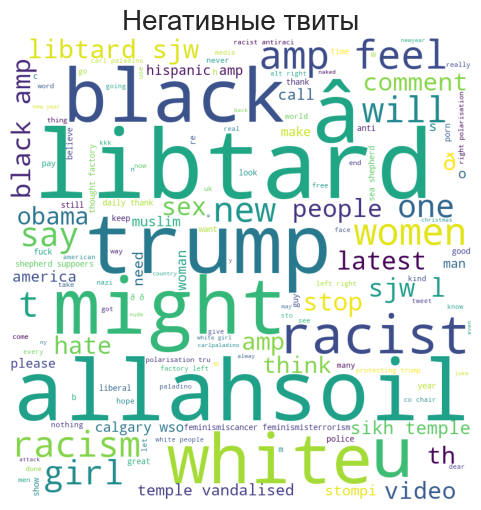

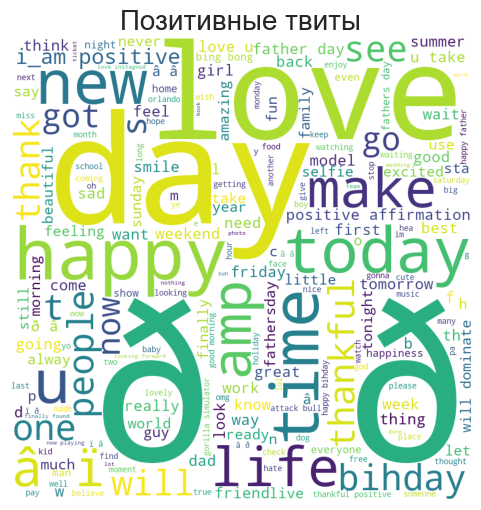

In [9]:
negative_tweets = train_df['tweet'][train_df['label'] == 1].to_string()
positive_tweets = train_df['tweet'][train_df['label'] == 0].to_string()

plot_wordcloud(negative_tweets, 'Негативные твиты')
plot_wordcloud(positive_tweets, 'Позитивные твиты')

# Изучим данные

In [10]:
train_df_fe = train_df.copy()
train_df_fe['tweet_length'] = train_df_fe['tweet'].str.len()
train_df_fe['num_hashtags'] = train_df_fe['tweet'].str.count('#')
train_df_fe['num_voskl'] = train_df_fe['tweet'].str.count('!')
train_df_fe['num_vopros'] = train_df_fe['tweet'].str.count('\?')
train_df_fe['total_tags'] = train_df_fe['tweet'].str.count('@')
train_df_fe['num_punctuations'] = train_df_fe['tweet'].str.count('[.,:;]')
train_df_fe['num_words'] = train_df_fe['tweet'].apply(lambda x: len(x.split()))
train_df_fe.head()

,id,label,tweet,tweet_length,num_hashtags,num_voskl,num_vopros,total_tags,num_punctuations,num_words
0,1,0,@user when a father is dysfunctional and is s...,102,1,0,0,1,1,18
1,2,0,@user @user thanks for #lyft credit i can't us...,122,3,0,0,2,1,19
2,3,0,bihday your majesty,21,0,0,0,0,0,3
3,4,0,#model i love u take with u all the time in ...,86,1,3,0,0,0,14
4,5,0,factsguide: society now #motivation,39,1,0,0,0,1,4


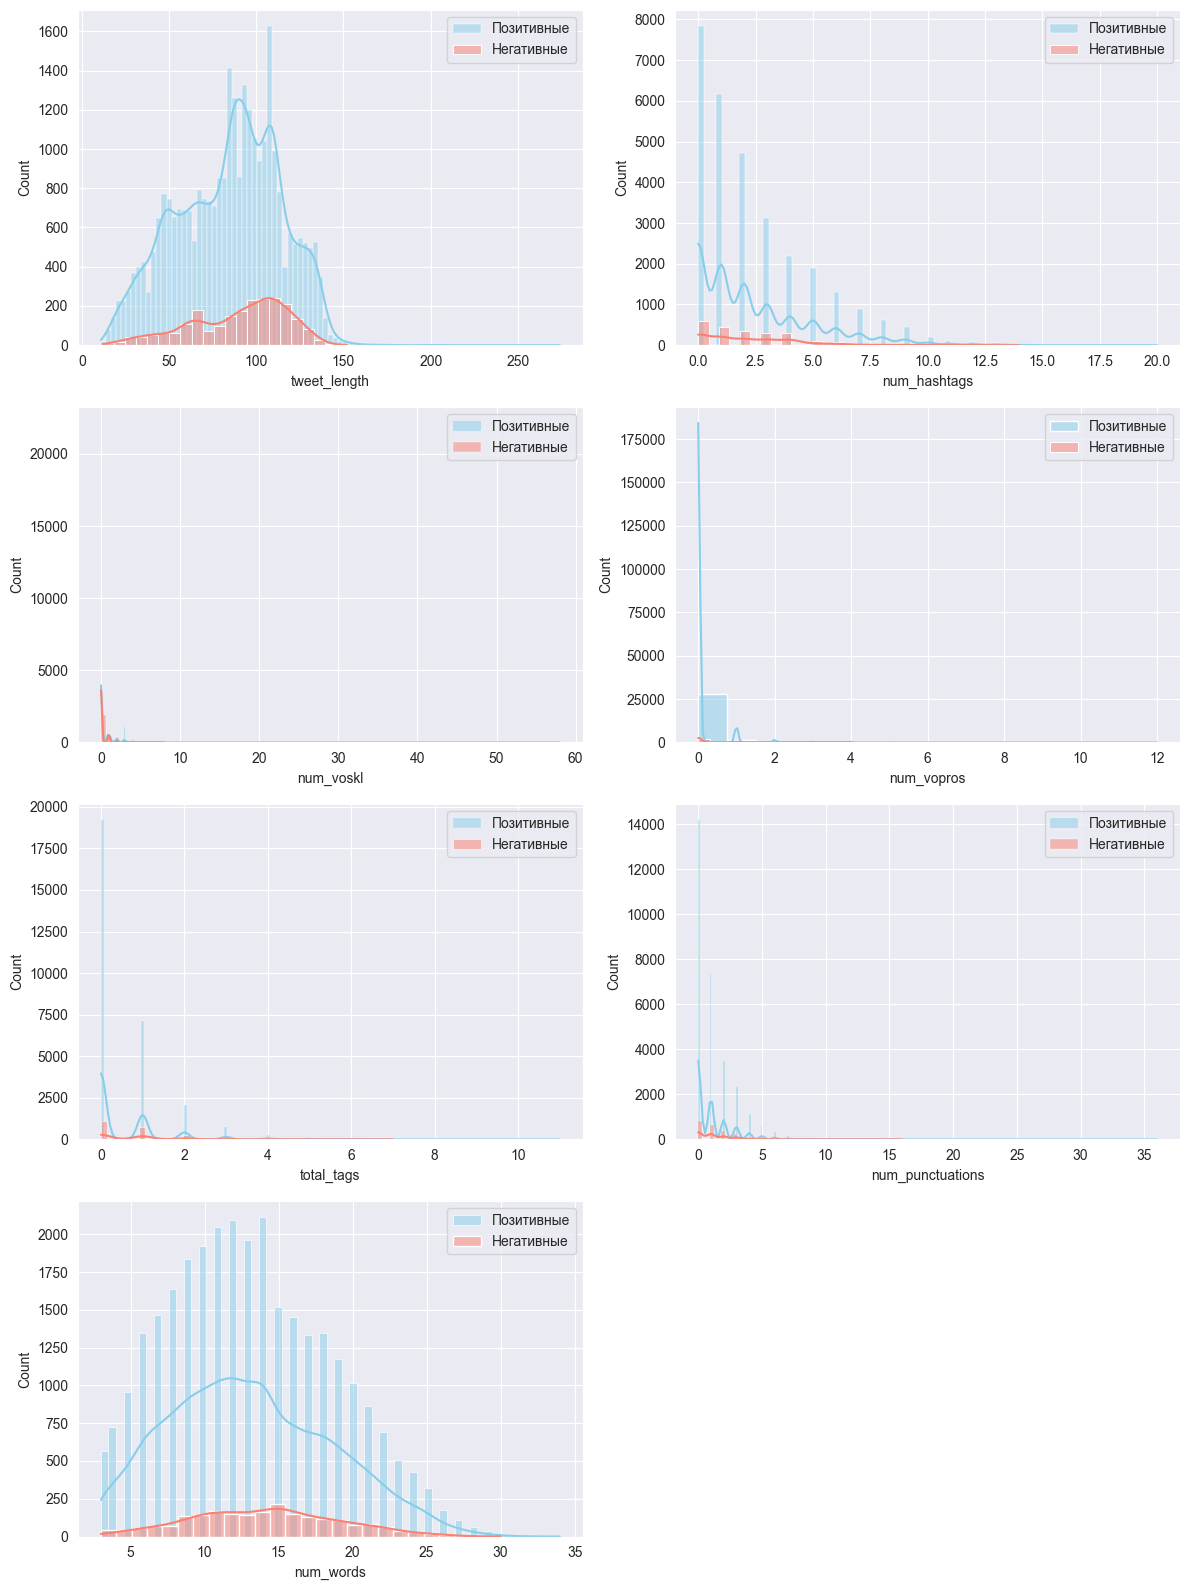

In [11]:
# График взаимосвязи наших функций с настроениями
features = ['tweet_length', 'num_hashtags', 'num_voskl', 'num_vopros', 'total_tags',
            'num_punctuations', 'num_words']

# Проверьте, содержит ли train_df_fe ожидаемые столбцы
if set(features).issubset(train_df_fe.columns):
    plt.figure(figsize=(12, 16))
    colors = ['skyblue', 'salmon']

    for i, feature in enumerate(features, 1):
        plt.subplot(4, 2, i)
        sns.histplot(train_df_fe[train_df_fe.label == 0][feature], label='Позитивные', kde=True, color=colors[0])
        sns.histplot(train_df_fe[train_df_fe.label == 1][feature], label='Негативные', kde=True, color=colors[1])
        plt.legend()

    plt.tight_layout()
    plt.show()

# Предобработка данных

In [12]:
X = train_df.drop(columns=['label'])
y = train_df['label']
test = test_df

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Нормализация текста

In [14]:
def tokenize_and_clean(text):
    lowered = text.lower()
    cleaned = re.sub('@user', '', lowered)
    tokens = word_tokenize(cleaned)
    filtered_tokens = [token for token in tokens if re.match(r'\w{1,}', token)]
    stemmer = PorterStemmer()
    stems = [stemmer.stem(token) for token in filtered_tokens]
    return stems

## Векторизация текста

In [16]:
tfidf_vectorizer = TfidfVectorizer(tokenizer=tokenize_and_clean, stop_words='english')
X_train_tweets_tfidf = tfidf_vectorizer.fit_transform(X_train['tweet'])
X_test_tweets_tfidf = tfidf_vectorizer.transform(X_test['tweet'])
X_tweets_tfidf = tfidf_vectorizer.fit_transform(X['tweet'])
test_tweets_tfidf = tfidf_vectorizer.transform(test['tweet'])

## Нагенерим синтетические данные для меньшего класса с помощью SMOTE

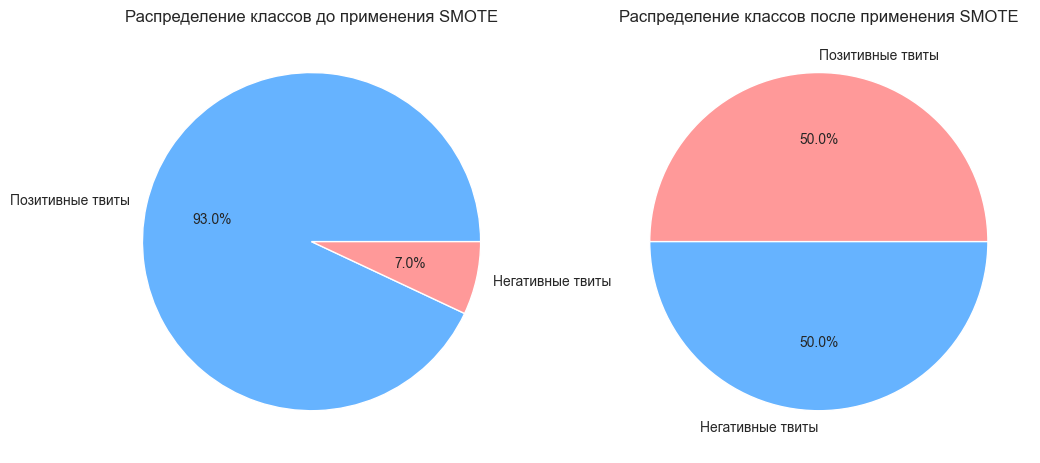

In [18]:
# Проверим дисбаланс классов ДО применения SMOTE
plt.figure(figsize=(12, 6))

colors_before_smote = ['#66b3ff', '#ff9999']
colors_after_smote = ['#ff9999', '#66b3ff']

labels = ['Позитивные твиты', 'Негативные твиты']

plt.subplot(1, 2, 1)
plt.pie(y_train.value_counts(), labels=labels, autopct='%0.1f%%', colors=colors_before_smote)
plt.title('Распределение классов до применения SMOTE')

# Применим SMOTE для борьбы с дисбалансом классов
smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_resample(X_train_tweets_tfidf, y_train.values)

plt.subplot(1, 2, 2)
plt.pie(pd.value_counts(y_train_smote), labels=labels, autopct='%0.1f%%', colors=colors_after_smote)
plt.title('Распределение классов после применения SMOTE')
plt.show()

# Используем ML модель

In [24]:
# Функции для вывода точности модели
def training_scores(y_act, y_pred):
    acc = round(accuracy_score(y_act, y_pred), 3)
    f1 = round(f1_score(y_act, y_pred), 3)
    print(f'Accuracy (train) = {acc}, F1 = {f1}')


def validation_scores(y_act, y_pred):
    acc = round(accuracy_score(y_act, y_pred), 3)
    f1 = round(f1_score(y_act, y_pred), 3)
    print(f'Accuracy (test_val) = {acc}, F1 = {f1}')

In [21]:
def train_and_evaluate(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    training_scores(y_train, y_train_pred)
    validation_scores(y_test, y_test_pred)

In [25]:
# Логистическая регрессия
lr = LogisticRegression()
train_and_evaluate(lr, X_train_smote, y_train_smote, X_test_tweets_tfidf, y_test)

Accuracy (train) = 0.974, F1 = 0.975
Accuracy (test_val) = 0.924, F1 = 0.602


In [26]:
# Наивный Байесовский классификатор
mnb = MultinomialNB()
train_and_evaluate(mnb, X_train_smote, y_train_smote, X_test_tweets_tfidf, y_test)

Accuracy (train) = 0.967, F1 = 0.968
Accuracy (test_val) = 0.922, F1 = 0.611


In [28]:
# Классификатор случайного леса
rf = RandomForestClassifier(verbose=10, n_jobs=20)
train_and_evaluate(rf, X_train_smote, y_train_smote, X_test_tweets_tfidf, y_test)

[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100


[Parallel(n_jobs=20)]: Done   1 tasks      | elapsed:    2.1s


building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    2.5s


building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100


[Parallel(n_jobs=20)]: Done  21 tasks      | elapsed:    4.1s


building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100


[Parallel(n_jobs=20)]: Done  32 tasks      | elapsed:    4.6s


building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100


[Parallel(n_jobs=20)]: Done  45 tasks      | elapsed:    6.1s


building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100


[Parallel(n_jobs=20)]: Done  58 tasks      | elapsed:    7.5s


building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100


[Parallel(n_jobs=20)]: Done  72 out of 100 | elapsed:    9.2s remaining:    3.5s


building tree 93 of 100
building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=20)]: Done  83 out of 100 | elapsed:   10.2s remaining:    2.0s
[Parallel(n_jobs=20)]: Done  94 out of 100 | elapsed:   11.0s remaining:    0.6s
[Parallel(n_jobs=20)]: Done 100 out of 100 | elapsed:   11.2s finished
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  21 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  32 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  45 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done  58 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done  72 out of 100 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  83 out of 100 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  94 out of 100 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=20)]: Done 100 out of 100 | elapsed:    0.2s finished

Accuracy (train) = 1.0, F1 = 1.0
Accuracy (test_val) = 0.956, F1 = 0.655


In [29]:
# Градиетный бустинг
xgb = XGBClassifier(objective='binary:logistic', eval_metric='logloss')
train_and_evaluate(xgb, X_train_smote, y_train_smote, X_test_tweets_tfidf, y_test)

Accuracy (train) = 0.942, F1 = 0.94
Accuracy (test_val) = 0.943, F1 = 0.605


# Проведём файнтюнинг гиперпараметров

In [30]:
rf_tuned = RandomForestClassifier(criterion='entropy',
                                  max_samples=0.8,
                                  min_samples_split=10,
                                  random_state=0,
                                  n_jobs=20,
                                  verbose=10)
train_and_evaluate(rf_tuned, X_train_smote, y_train_smote, X_test_tweets_tfidf, y_test)

[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.


building tree 1 of 100building tree 2 of 100

building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100


[Parallel(n_jobs=20)]: Done   1 tasks      | elapsed:    1.6s


building tree 25 of 100building tree 26 of 100

building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    1.9s


building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100building tree 42 of 100

building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100


[Parallel(n_jobs=20)]: Done  21 tasks      | elapsed:    3.1s


building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100


[Parallel(n_jobs=20)]: Done  32 tasks      | elapsed:    3.7s


building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100


[Parallel(n_jobs=20)]: Done  45 tasks      | elapsed:    4.6s


building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100


[Parallel(n_jobs=20)]: Done  58 tasks      | elapsed:    5.6s


building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100


[Parallel(n_jobs=20)]: Done  72 out of 100 | elapsed:    6.8s remaining:    2.6s


building tree 93 of 100
building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=20)]: Done  83 out of 100 | elapsed:    7.4s remaining:    1.4s
[Parallel(n_jobs=20)]: Done  94 out of 100 | elapsed:    8.0s remaining:    0.4s
[Parallel(n_jobs=20)]: Done 100 out of 100 | elapsed:    8.1s finished
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  21 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  32 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  45 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done  58 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done  72 out of 100 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  83 out of 100 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  94 out of 100 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=20)]: Done 100 out of 100 | elapsed:    0.2s finished

Accuracy (train) = 0.999, F1 = 0.999
Accuracy (test_val) = 0.955, F1 = 0.665


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  21 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  32 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  45 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  58 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  72 out of 100 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  83 out of 100 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  94 out of 100 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done 100 out of 100 | elapsed:    0.0s finished


In [31]:
xgb_tuned = XGBClassifier(objective='binary:logistic',
                          eval_metric='logloss',
                          learning_rate=0.8,
                          max_depth=20,
                          gamma=0.6,
                          reg_lambda=0.1,
                          reg_alpha=0.1)
train_and_evaluate(xgb_tuned, X_train_smote, y_train_smote, X_test_tweets_tfidf, y_test)

Accuracy (train) = 0.998, F1 = 0.998
Accuracy (test_val) = 0.956, F1 = 0.661
